# Day 8 - Open Street Maps

Accessing OSM data using Overpass API. 

Good article [here](https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0)

In [20]:
import requests
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager

#for colorbar
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# London's chicken shops


## get and clean OSM data
Get chicken shops + known brands by name (if not tagged with cuisine)

Helpful [tip](https://help.openstreetmap.org/questions/48794/overpass-api-union-doesnt-work) when debugging union code. 

In [2]:
#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="Greater London"][admin_level=5]->.searchArea;

(node["cuisine"="chicken"](area.searchArea); 
 way["cuisine"="chicken"](area.searchArea);
 rel["cuisine"="chicken"](area.searchArea);
 node["name"~"KFC|Morley's|Nando's|^Chicken|Piri Piri|Peri Peri"](area.searchArea);
 way["name"~"KFC|Morley's|Nando's|^Chicken|Piri Piri|Peri Peri"](area.searchArea);
 rel["name"~"KFC|Morley's|Nando's|^Chicken|Piri Piri|Peri Peri"](area.searchArea);
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [3]:
#convert json into dataframe
df_dict = {"id":[], "type": [], "lat":[], "lon": [], "name":[],"brand":[], "cuisine":[], "amenity":[]}

for element in data['elements']:
    df_dict["id"].append(element["id"])
    df_dict["type"].append(element["id"])
    
    for tag in ["name", "brand", "cuisine", "amenity"]:
        try:
            df_dict[tag].append(element["tags"][tag])
        except KeyError:
            df_dict[tag].append("") 
    if element["type"]=="node":
        df_dict["lat"].append(element["lat"])
        df_dict["lon"].append(element["lon"])
    else:
        df_dict["lat"].append(element["center"]["lat"])
        df_dict["lon"].append(element["center"]["lon"])
        
df = pd.DataFrame.from_dict(df_dict)

In [4]:
# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)
gdf.head()

,id,type,lat,lon,name,brand,cuisine,amenity,geometry
0,59932133,59932133,51.377740,-0.025343,KFC,KFC,chicken,fast_food,POINT (-0.02534 51.37774)
1,130216826,130216826,51.413614,-0.178088,Nando's,Nando's,chicken;portuguese,restaurant,POINT (-0.17809 51.41361)
2,249249967,249249967,51.617862,-0.311072,Nando's,Nando's,chicken;portuguese,restaurant,POINT (-0.31107 51.61786)
3,260283878,260283878,51.540145,-0.143901,KFC,KFC,chicken,fast_food,POINT (-0.14390 51.54015)
4,265255759,265255759,51.510171,-0.287978,Nando's,Nando's,chicken;portuguese,restaurant,POINT (-0.28798 51.51017)


In [5]:
#create column for chain or no chain
chain = []

for i in range(len(gdf)):
    if gdf["name"][i] in list(gdf["name"].value_counts().head(2).index):
        chain.append(gdf["name"][i])
    #elif gdf["name"][i] in list(gdf["name"].value_counts()[2:25].index):
       # chain.append("Local chain")
    else:
        chain.append("Independent/local")

gdf["chain"] = chain
gdf["chain_binary"] = ["International chain" if i=="KFC" or i=="Nando's" else "Independent/local" for i in gdf["chain"]]

In [6]:
gdf.head()

,id,type,lat,lon,name,brand,cuisine,amenity,geometry,chain,chain_binary
0,59932133,59932133,51.377740,-0.025343,KFC,KFC,chicken,fast_food,POINT (-0.02534 51.37774),KFC,International chain
1,130216826,130216826,51.413614,-0.178088,Nando's,Nando's,chicken;portuguese,restaurant,POINT (-0.17809 51.41361),Nando's,International chain
2,249249967,249249967,51.617862,-0.311072,Nando's,Nando's,chicken;portuguese,restaurant,POINT (-0.31107 51.61786),Nando's,International chain
3,260283878,260283878,51.540145,-0.143901,KFC,KFC,chicken,fast_food,POINT (-0.14390 51.54015),KFC,International chain
4,265255759,265255759,51.510171,-0.287978,Nando's,Nando's,chicken;portuguese,restaurant,POINT (-0.28798 51.51017),Nando's,International chain


## get London boroughs shapefile



In [7]:
#load london boroughs
london = gpd.GeoDataFrame.from_file("London_Borough_Excluding_MHW.geojson")
london = london.to_crs('4326')

In [8]:
#join points into boroughs and calculate stats 
borough_stats = gpd.sjoin(gdf, london, how="left")
borough_stats = borough_stats.groupby(["NAME", "chain_binary"])["id"].count().to_frame().unstack()
borough_stats.columns = borough_stats.columns.droplevel(level=0)
borough_stats["Total"] = borough_stats.sum(axis=1)
borough_stats["Chain_ratio"] = (borough_stats["International chain"] / borough_stats["Total"])
borough_stats = borough_stats.reset_index()
borough_stats.head()

chain_binary,NAME,Independent/local,International chain,Total,Chain_ratio
0,Barking and Dagenham,9,3,12,0.250000
1,Barnet,4,9,13,0.692308
2,Bexley,1,6,7,0.857143
3,Brent,28,8,36,0.222222
4,Bromley,7,8,15,0.533333


In [9]:
#join back with london frame
london = pd.merge(london, borough_stats, left_on="NAME", right_on="NAME", how="left")
london.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,Independent/local,International chain,Total,Chain_ratio
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51...",1,5,6,0.833333
1,Croydon,E09000008,8649.441,0.000,F,None,None,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51...",26,10,36,0.277778
2,Bromley,E09000006,15013.487,0.000,F,None,None,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2...",7,8,15,0.533333
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51...",7,5,12,0.416667
4,Ealing,E09000009,5554.428,0.000,F,None,None,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51...",17,7,24,0.291667


## Map

Create custom color map using [palettable](https://jiffyclub.github.io/palettable/) (truncate function thanks to [Stackoverflow](https://stackoverflow.com/questions/40929467/how-to-use-and-plot-only-a-part-of-a-colorbar-in-matplotlib))

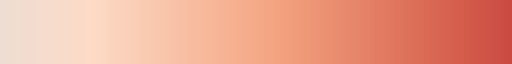

In [10]:
from palettable.colorbrewer.diverging import RdGy_8_r,  RdGy_8

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

minColor = 0.5
maxColor = 0.9
new_cmap = truncate_colormap(plt.get_cmap(RdGy_8_r.mpl_colormap), minColor, maxColor)
new_cmap

Plot data

In [279]:
#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

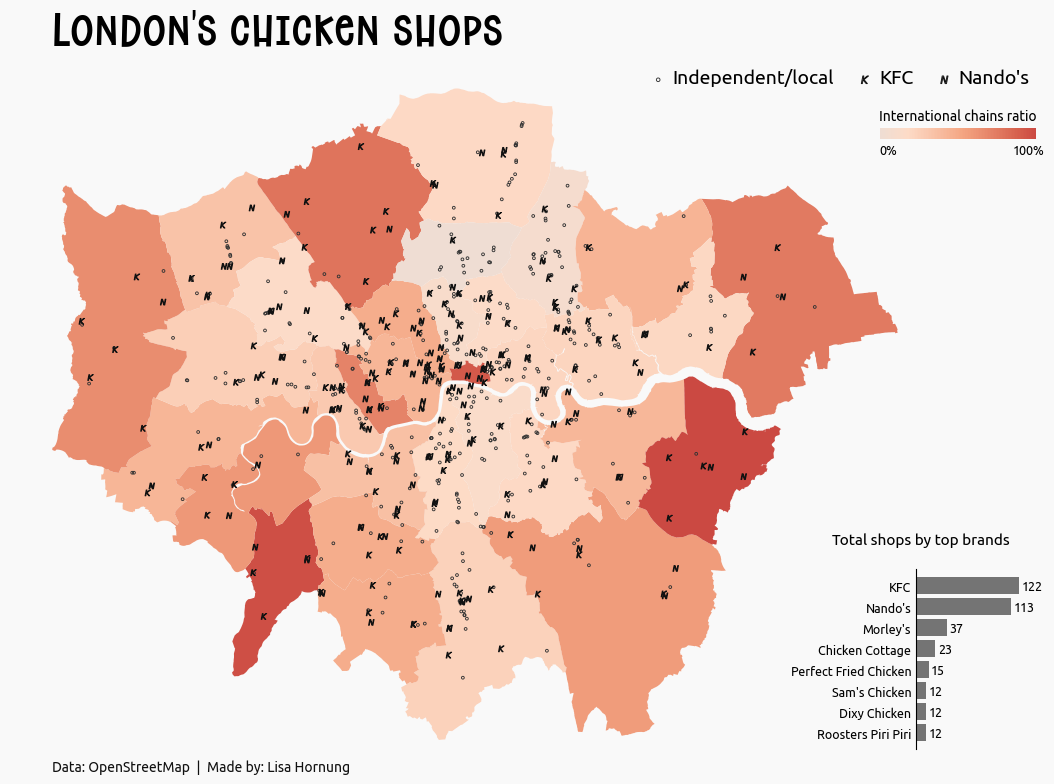

In [21]:
#ensure both datasets are using the same projection
london = london.to_crs('3857')
gdf = gdf.to_crs('3857')

#configuration, colors and fonts
fig, ax = plt.subplots(figsize=(12, 10))
title_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Chicken Dinner Font by  7NTypes.otf')
label_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Ubuntu-R.ttf')
cols = {"KFC": '#111111', "Nando's": '#111111', 'Independent/local': '#333333', "bg": "#f9f9f9", "bar": "#747474"}
mtype = {"KFC": r"$K$", "Nando's": r"$N$", 'Independent/local': 'o' } #set custom markers
stype = {"KFC": 18,  "Nando's": 18,'Independent/local': 4 }
color = new_cmap
fig.set_facecolor(cols["bg"])

# ======
#plot london boroughs and chicken shops
london.plot(ax=ax, column="Chain_ratio", alpha=1, zorder=1, cmap=color)
for _type, data in gdf.groupby('chain'):
    data.plot(ax=ax, label=_type, edgecolor=cols[_type], linewidth=0.65, 
              markersize=stype[_type], marker = mtype[_type], facecolors='none', 
              alpha=1, vmin=0, vmax=1)
ax.axis("off")

# ==========
#bar chart
labels = list(gdf["name"].value_counts().head(8).sort_values().index)
values = gdf["name"].value_counts().head(8).sort_values().values
y_pos = np.arange(1,9,1)

baxes = fig.add_axes([0.88, 0.16, 0.09, 0.18]) #axes to hold bar chart
baxes.barh(y_pos, values, height=0.8, linewidth=0, color=cols["bar"])
baxes.text(-100,10,"Total shops by top brands", fontsize=11, ha="left", fontproperties = label_font)
for i in range(len(values)):
    baxes.text(values[i]+3, y_pos[i] , values[i], va="center", fontsize=9, fontproperties = label_font)

# format axis
baxes.tick_params(axis='y', length = 0, color = "#444444")
baxes.set_yticks(np.arange(1,9,1), labels, fontsize=9, fontproperties = label_font)
for pos in ["top", "bottom", "right"]:
    baxes.spines[pos].set_visible(False)
baxes.set_facecolor(cols["bg"])
baxes.xaxis.set_visible(False)

# ==========
#add legend
L = ax.legend(ncol=3, frameon=False, loc='upper right',bbox_to_anchor=(1.11,1.0), handletextpad=0.05,
             markerscale=1.3, columnspacing=1.2, )
plt.setp(L.texts, fontsize=14, fontproperties = label_font)
    
#======
#colorbar
cbaxes = fig.add_axes([0.85, 0.77, 0.13, 0.011]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=color)                      
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False,ticks=[0.05,0.95])
cb.set_ticklabels(["0%","100%" ], size=9, va='top', fontproperties = label_font)
cb.outline.set_visible(False)
cbaxes.tick_params(size=0)
cbaxes.text(0.5, 1.7, "International chains ratio", ha="center", size=10,  fontproperties = label_font)

# ======
# Footer and title
plt.figtext(0.16,0.9, "London's chicken shops", fontproperties = title_font, va='top', fontsize=35)
plt.figtext(0.16,0.15, "Data: OpenStreetMap  |  Made by: Lisa Hornung", color="#111111", fontsize=10, va="top",
           fontproperties = label_font)

#save
plt.savefig("londons-chicken-shops.png", bbox_inches='tight',  transparent=False, pad_inches=0.45)
plt.savefig("londons-chicken-shops_transparent.png", bbox_inches='tight',  transparent=True, pad_inches=0.25)

plt.show()

# Other explorations

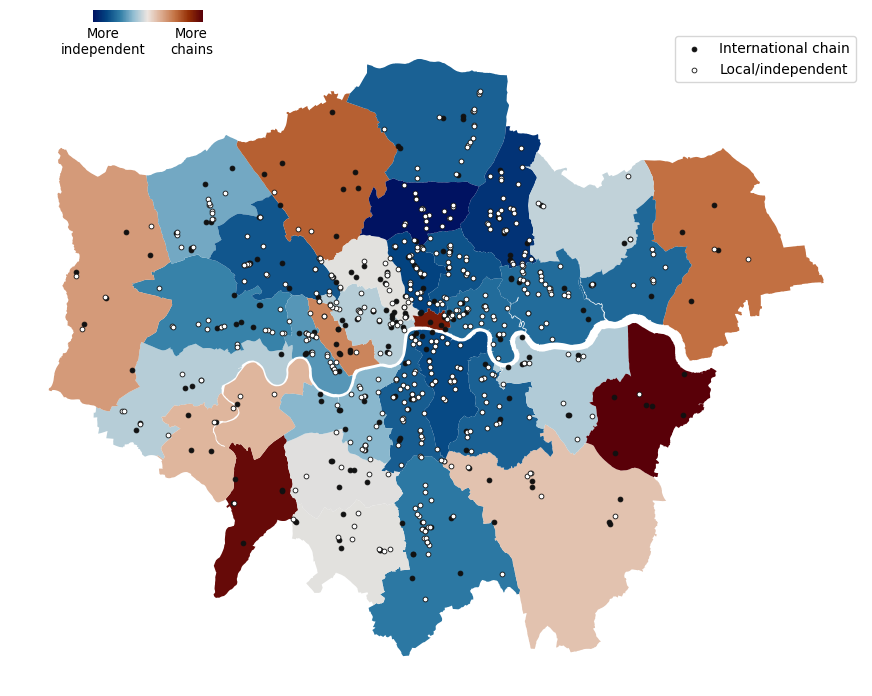

In [261]:
#configuration, colors and fonts
fig, ax = plt.subplots(figsize=(11, 11))
fill = {"International chain": '#111111', 'Local/independent': '#FFFFFF'}
color = Vik_9

# ======
#plot london boroughs and chicken shopt
london.plot(ax=ax, column="Chain_ratio", alpha=1, zorder=1, cmap=color.mpl_colormap)
for ctype, data in gdf.groupby('chain_binary'):
    data.plot(color=fill[ctype], ax=ax, label=ctype, edgecolor="#111111", linewidth=0.6, markersize=12,alpha=1,
              vmin=0, vmax=1)

#======
#legend    
plt.legend()
    
#======
#colorbar
cbaxes = fig.add_axes([0.20, 0.8, 0.10, 0.011]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=color.mpl_colormap)                      
cb = plt.colorbar(cmappable, cax=cbaxes, anchor=(1,1.2), orientation='horizontal', drawedges=False,ticks=[0.1,0.9])
cb.set_ticklabels(["More\nindependent","More\nchains" ], size=9.5, va='top')
cbaxes.tick_params(size=0)
cb.outline.set_visible(False)
#cb.outline.set_linewidth(0.5)
    
ax.axis("off")

plt.show()

In [49]:
df["name"].value_counts()

KFC                      121
Nando's                  113
Morley's                  37
Chicken Cottage           23
Perfect Fried Chicken     15
                        ... 
Dixie Grill                1
Bite House                 1
Chicken n Grill            1
Chicken Hut                1
Chesters                   1
Name: name, Length: 300, dtype: int64

(-61514.549612463816, 41882.29920675949, 6668554.536441356, 6748224.297332849)

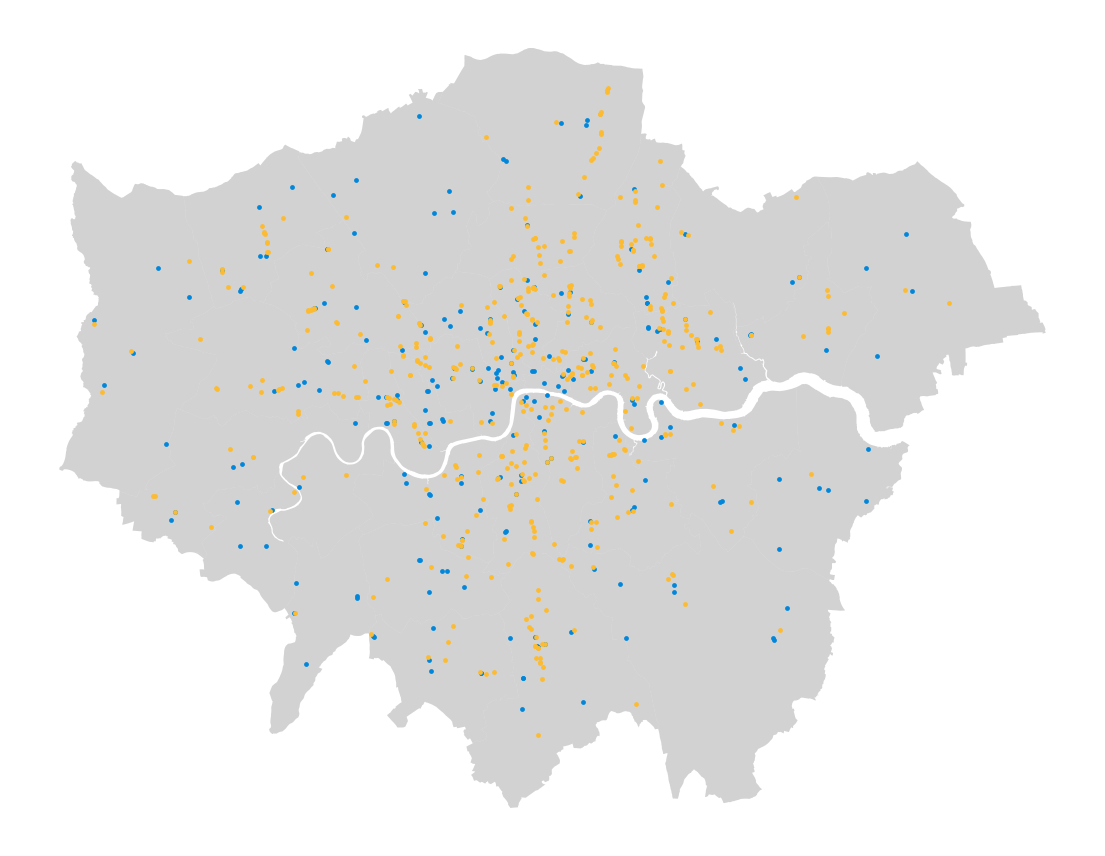

In [221]:
fig, ax = plt.subplots(figsize=(14, 14))
cols = {"International chain": '#0087DC', 'Local/independent': '#FDBB30'}

london.plot(ax=ax, color="grey", alpha=0.35, zorder=1)

for ctype, data in gdf.groupby('chain_binary'):
    color = cols[ctype]
    label = ctype
    data.plot(color=color, ax=ax, label=label, edgecolor="#333333", linewidth=0, markersize=12,alpha=1)

#gdf.plot(ax=ax, color="black", markersize=5, alpha=0.35, zorder=2)
#cx.add_basemap(ax=ax, crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLabels, attribution="", zoom=10)
ax.axis("off")

# Example

In [10]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="DE"][admin_level=2]->.searchArea;

(node["amenity"="biergarten"](area.searchArea);
 way["amenity"="biergarten"](area.searchArea);
 rel["amenity"="biergarten"](area.searchArea);
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

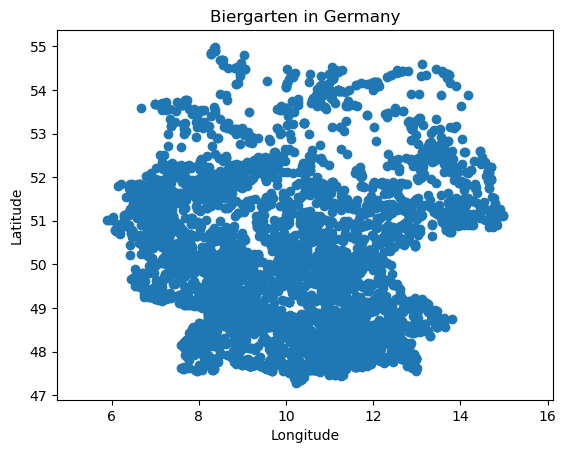

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Collect coords into list
coords = []
for element in data['elements']:
  if element['type'] == 'node':
    lon = element['lon']
    lat = element['lat']
    coords.append((lon, lat))
  if 'center' in element:
    lon = element['center']['lon']
    lat = element['center']['lat']
    coords.append((lon, lat))# Convert coordinates into numpy array
X = np.array(coords)
plt.plot(X[:, 0], X[:, 1], 'o')
plt.title('Biergarten in Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()